# Price Data Extraction for Post-Index Rebalancing Arbitrage Strategy

Data source: Refinitiv Datastream via WRDS

This notebook executes codes to extract relevant data, based on the historical records of FTSE100 and FTSE250 rebalancing, for the past 10 years (2013Q1 - 2023Q3).
In this exercise, the following stocks are excluded:
- Stocks that are suspended from trading within the analysis period (+/- 20 days from rebalancing date)
- Stocks which rebalancing dates fall within the announcement date and the ex date of a corporate action
- Stocks that we are unable to obtain a reliable historical data on
- All Q3 2023 rebalancing; at time of study we are unable to obtain 20 days after the rebalancing date

In [73]:
# Import WRDS library
import wrds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

# Statistical package
from scipy import stats

/Users/abigail/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Extraction

In [2]:
def read_sql_script(fname):
    fd = open(fname, 'r')
    sqlFile = fd.read()
    fd.close()

    return sqlFile


# Get current path
current_dir = os.getcwd()


# Define sql file names
# these will be used as a global variable
query_historical_prices = read_sql_script('../SQL/get_historical_prices.sql')
query_shares_outstanding = read_sql_script('../SQL/get_shares_outstanding.sql')

# Establish live connection; requires user login (passwords will be masked)
db = wrds.Connection() # this will be used as a global variable


def get_historical_prices(isin, start_date, end_date):
    
    # print(f'Extracting historical prices for {isin}...')

    df =\
    (
        db
        .raw_sql(
            query_historical_prices.format(isin, start_date, end_date), 
            date_cols = ['trade_date']
            )
    )

    if df.empty:
        print('Dataframe is empty. No results was returned!')
    
    # print('--------------------------------------------------')

    return df


Enter your WRDS username [abigail]:abigailcjh
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [3]:
ftse_rebal = pd.read_csv(f'../constituent_history/ftse_10y_rebal_records.csv')


In [4]:
look_back = 40
look_forward = 40

ftse_rebal["Post Date"] =\
    pd.to_datetime(ftse_rebal["Post Date"], 
                   format = '%d/%m/%Y')

ftse_rebal["start_date"] =\
    (
        ftse_rebal["Post Date"] - timedelta(days = look_back)
    ).dt.strftime('%d/%m/%Y')

ftse_rebal["end_date"] =\
    (
        ftse_rebal["Post Date"] + timedelta(days = look_back)
    ).dt.strftime('%d/%m/%Y')

ftse_rebal

,Post Date,Name,ISIN,FTSE100,FTSE250,start_date,end_date
0,2023-09-18,888 Holdings,GI000A0F6407,NaN,1.0,09/08/2023,28/10/2023
1,2023-09-18,Abrdn,GB00BF8Q6K64,-1.0,1.0,09/08/2023,28/10/2023
2,2023-09-18,Breedon Group,GB00BM8NFJ84,NaN,1.0,09/08/2023,28/10/2023
3,2023-09-18,CAB Payments Holdings,GB00BMCYKB41,NaN,1.0,09/08/2023,28/10/2023
4,2023-09-18,Capita,GB00B23K0M20,NaN,-1.0,09/08/2023,28/10/2023
...,...,...,...,...,...,...,...
576,2013-03-18,London Stock Exchange Group,GB00B0SWJX34,1.0,-1.0,06/02/2013,27/04/2013
577,2013-03-18,NMC Health,GB00B7FC0762,NaN,1.0,06/02/2013,27/04/2013
578,2013-03-18,Raven Russia,GB00B0D5V538,NaN,-1.0,06/02/2013,27/04/2013
579,2013-03-18,Stobart Group,GB00B03HDJ73,NaN,-1.0,06/02/2013,27/04/2013


In [5]:
target_isins = ftse_rebal["ISIN"]
start_dates = ftse_rebal["start_date"]
end_dates = ftse_rebal["end_date"]   


historical_prices =\
    (
        pd.
        concat(
            map(
                get_historical_prices,
                target_isins,
                start_dates,
                end_dates
            )
        )
    )

Dataframe is empty. No results was returned!
Dataframe is empty. No results was returned!
Dataframe is empty. No results was returned!
Dataframe is empty. No results was returned!
Dataframe is empty. No results was returned!


/var/folders/mv/kbtg0d9s34s4w1xjw4w31b0h0000gn/T/ipykernel_69247/4165491479.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.


In [6]:
historical_prices.head()

,trade_date,security_code,security_name,primary_exchange,refinitiv_code,isin_code,currency,open,high,low,close,volume
0,2023-08-09,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.066,1.136,1.063000,1.117,358252.0
1,2023-08-10,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.140,1.140,1.091000,1.120,284950.0
2,2023-08-11,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.100,1.331,1.098000,1.150,1003896.0
3,2023-08-14,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.147,1.160,1.088108,1.096,1088784.0
4,2023-08-15,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.100,1.126,1.001000,1.114,1127118.0


## Data Cleaning

In [7]:

index_close_data = pd.read_csv('../output/FTSE_100_Index_10y.csv', header = 0) 
#o

index_close_data["Date"] =\
    (
        index_close_data["Date"]
        .apply(lambda x: datetime.strptime(x,'%d/%m/%y'))
    )


In [ ]:
index_close_data.head()

In [8]:
full_ftse_data = historical_prices.copy()

In [9]:
## Use this instead
full_ftse_data =\
(
    full_ftse_data
    .merge(
        index_close_data[['Date', 'Close']],
        how = 'left',
        left_on = 'trade_date',
        right_on = 'Date'
    )
)

full_ftse_data.head()

,trade_date,security_code,security_name,primary_exchange,refinitiv_code,isin_code,currency,open,high,low,close,volume,Date,Close
0,2023-08-09,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.066,1.136,1.063000,1.117,358252.0,2023-08-09,7587.30
1,2023-08-10,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.140,1.140,1.091000,1.120,284950.0,2023-08-10,7618.60
2,2023-08-11,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.100,1.331,1.098000,1.150,1003896.0,2023-08-11,7524.16
3,2023-08-14,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.147,1.160,1.088108,1.096,1088784.0,2023-08-14,7507.15
4,2023-08-15,18982.0,888 HOLDINGS,LON,26862.0,GI000A0F6407,GBP,1.100,1.126,1.001000,1.114,1127118.0,2023-08-15,7389.64


In [ ]:
full_ftse_data.info()

In [10]:
lse_historical_prices =\
    full_ftse_data[['trade_date', 'security_name', 'primary_exchange','isin_code', 
                    'currency', 'close', 'volume', 'Close']]\
        .loc[full_ftse_data.primary_exchange == 'LON', :]\
            .copy()

lse_historical_prices =\
    lse_historical_prices.rename(columns = {'Close':'index_close'})

lse_historical_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32137 entries, 0 to 32789
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   trade_date        32137 non-null  datetime64[ns]
 1   security_name     32137 non-null  object        
 2   primary_exchange  32137 non-null  object        
 3   isin_code         32137 non-null  object        
 4   currency          32137 non-null  object        
 5   close             32137 non-null  float64       
 6   volume            32130 non-null  float64       
 7   index_close       32077 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 2.2+ MB


In [11]:
rebal_round = {
    1 : 'Q4',
    2 : 'Q1',
    3 : 'Q1',
    4 : 'Q1',
    5 : 'Q2',
    6 : 'Q2',
    7 : 'Q2',
    8 : 'Q3',
    9 : 'Q3',
    10 : 'Q3',
    11 : 'Q4',
    12 : 'Q4',
}

In [12]:
lse_historical_prices['year'] = lse_historical_prices['trade_date'].dt.year
lse_historical_prices['month'] = lse_historical_prices['trade_date'].dt.month
lse_historical_prices['rebal'] =\
(
    (lse_historical_prices['year'] 
     - 1*(lse_historical_prices['month'] == 1)).astype(str)
    + lse_historical_prices['month'].map(rebal_round)
)

lse_historical_prices.head()

,trade_date,security_name,primary_exchange,isin_code,currency,close,volume,index_close,year,month,rebal
0,2023-08-09,888 HOLDINGS,LON,GI000A0F6407,GBP,1.117,358252.0,7587.30,2023,8,2023Q3
1,2023-08-10,888 HOLDINGS,LON,GI000A0F6407,GBP,1.120,284950.0,7618.60,2023,8,2023Q3
2,2023-08-11,888 HOLDINGS,LON,GI000A0F6407,GBP,1.150,1003896.0,7524.16,2023,8,2023Q3
3,2023-08-14,888 HOLDINGS,LON,GI000A0F6407,GBP,1.096,1088784.0,7507.15,2023,8,2023Q3
4,2023-08-15,888 HOLDINGS,LON,GI000A0F6407,GBP,1.114,1127118.0,7389.64,2023,8,2023Q3


In [13]:
# Remove Q3 2023 Rebal due to incomplete data
lse_historical_prices =\
    lse_historical_prices[lse_historical_prices['rebal'] != '2023Q3']

lse_historical_prices.head()

,trade_date,security_name,primary_exchange,isin_code,currency,close,volume,index_close,year,month,rebal
1000,2023-05-10,ASOS,LON,GB0030927254,GBP,4.873999,3884045.0,7741.33,2023,5,2023Q2
1001,2023-05-11,ASOS,LON,GB0030927254,GBP,5.000000,6081492.0,7730.58,2023,5,2023Q2
1002,2023-05-12,ASOS,LON,GB0030927254,GBP,5.050000,3685914.0,7754.62,2023,5,2023Q2
1003,2023-05-15,ASOS,LON,GB0030927254,GBP,4.005000,5816469.0,7777.70,2023,5,2023Q2
1004,2023-05-16,ASOS,LON,GB0030927254,GBP,3.988999,1900093.0,7751.08,2023,5,2023Q2


In [14]:
lse_historical_prices =\
    lse_historical_prices\
    .sort_values(by = ['security_name', 'trade_date'])\
    .reset_index(drop = True)

In [15]:
# Remove stocks that are suspended from trading during analysis period
suspended_stocks = [('GB00BJP5HK17', '2022Q4'), ('GB00B1VNST91', '2018Q2'), ('GB0007892358', '2017Q2')]

mask =\
    ~lse_historical_prices\
        .apply(lambda x: (x['isin_code'], x['rebal']) in suspended_stocks, axis = 1)


lse_historical_prices = lse_historical_prices[mask]

In [16]:
lse_historical_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31028 entries, 0 to 31136
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   trade_date        31028 non-null  datetime64[ns]
 1   security_name     31028 non-null  object        
 2   primary_exchange  31028 non-null  object        
 3   isin_code         31028 non-null  object        
 4   currency          31028 non-null  object        
 5   close             31028 non-null  float64       
 6   volume            31024 non-null  float64       
 7   index_close       31028 non-null  float64       
 8   year              31028 non-null  int32         
 9   month             31028 non-null  int32         
 10  rebal             31028 non-null  object        
dtypes: datetime64[ns](1), float64(3), int32(2), object(5)
memory usage: 2.6+ MB


## Get FTSE100/Stock to get Beta
Generate FTSE 100 Index Close based on Trade dates of Historical Price DF - get covariance for stock & index and variance for index, merged with each FTSE dropping/entering


In [17]:
def get_return(price_list):
    length = len(price_list) -1
    t1 = price_list[0:length]
    t2 = price_list[1:]

    result = np.array([(j / i -1) for i, j in zip(t1, t2)])
    
    return result

In [27]:
target_isins= ftse_rebal["ISIN"]
rebal_dates = ftse_rebal["Post Date"].dt.strftime('%d/%m/%Y')

target_rebal_prices = []
ind_target_rebal_prices = []


for isin, rebal_date in zip(target_isins, rebal_dates):

    if lse_historical_prices[(lse_historical_prices.isin_code == isin) 
                             & (lse_historical_prices.trade_date == rebal_date)].empty:
        continue
    
    else:
        sub_df = lse_historical_prices[lse_historical_prices.isin_code == isin]
        rebal_idx =\
        (
            sub_df
            .index[sub_df.trade_date == rebal_date]
            [0]
        )
        
        for delta in [-20, -5, -3, -1, 3, 5, 10, 20]:
            # Ensure that the prices for the days required exist
            assert sub_df['rebal'].loc[rebal_idx] == sub_df['rebal'].loc[rebal_idx + delta],\
            f'ISIN {isin} faced insufficient data pre-rebal on {rebal_date} for delta {delta} days'
        
        start_idx = rebal_idx - 20
        
        lst_stock_price = get_return(sub_df.close.loc[start_idx:rebal_idx])
        lst_index_close = get_return(sub_df.index_close.loc[start_idx:rebal_idx])
        lst_joint = [lst_stock_price, lst_index_close]

        cov_matrix = np.cov(lst_joint)
        cov = cov_matrix[0][1]
        var_stk = cov_matrix[0][0]
        var_idx = cov_matrix[1][1]
        
        beta = cov/var_idx
        corr = cov/np.sqrt(var_stk*var_idx)
        
        ind_pre_20_pd = sub_df.index_close.loc[rebal_idx - 20]
        ind_pre_5_pd = sub_df.index_close.loc[rebal_idx - 5]
        ind_pre_3_pd = sub_df.index_close.loc[rebal_idx - 3]
        ind_pre_1_pd = sub_df.index_close.loc[rebal_idx - 1]
        ind_post_3_pd = sub_df.index_close.loc[rebal_idx + 3]
        ind_post_5_pd = sub_df.index_close.loc[rebal_idx + 5]
        ind_post_10_pd = sub_df.index_close.loc[rebal_idx + 10]
        ind_post_20_pd = sub_df.index_close.loc[rebal_idx + 20]
        
        pre_20_pd = sub_df.close.loc[rebal_idx - 20]
        pre_5_pd = sub_df.close.loc[rebal_idx - 5]
        pre_3_pd = sub_df.close.loc[rebal_idx - 3]
        pre_1_pd = sub_df.close.loc[rebal_idx - 1]
        post_3_pd = sub_df.close.loc[rebal_idx + 3]
        post_5_pd = sub_df.close.loc[rebal_idx + 5]
        post_10_pd = sub_df.close.loc[rebal_idx + 10]
        post_20_pd = sub_df.close.loc[rebal_idx + 20]
        
        target_rebal_prices.append({
            'Name' : sub_df.security_name.values[0],
            'ISIN' : isin,
            'post_date' : rebal_date,
            'pre_twenty_pd' : pre_20_pd,
            'pre_five_pd' : pre_5_pd,
            'pre_three_pd' : pre_3_pd,
            'pre_one_pd' : pre_1_pd,
            'post_three_pd' : post_3_pd,
            'post_five_pd' : post_5_pd,
            'post_ten_pd' : post_10_pd,
            'post_twenty_pd' : post_20_pd,
        })
        
        ind_target_rebal_prices.append({
            'Name' : sub_df.security_name.values[0],
            'ISIN' : isin,
            'post_date' : rebal_date,
            'cov': cov,
            'var_stk': var_stk,
            'var_idx': var_idx,
            'beta': beta,
            'corr': corr,
            'ind_pre_twenty_pd' : ind_pre_20_pd,
            'ind_pre_five_pd' : ind_pre_5_pd,
            'ind_pre_three_pd' : ind_pre_3_pd,
            'ind_pre_one_pd' : ind_pre_1_pd,
            'ind_post_three_pd' : ind_post_3_pd,
            'ind_post_five_pd' : ind_post_5_pd,
            'ind_post_ten_pd' : ind_post_10_pd,
            'ind_post_twenty_pd' : ind_post_20_pd,
        })
        
    

In [28]:
target_data =\
    pd\
        .DataFrame(target_rebal_prices)

target_data['post_date'] = pd.to_datetime(target_data['post_date'])


target_data =\
    target_data.merge(
        ftse_rebal[['ISIN', 'Post Date', 'FTSE100', 'FTSE250']],
        how = 'left',
        left_on = ['ISIN', 'post_date'],
        right_on = ['ISIN', 'Post Date']
    )

target_data.head()


target_ind_data =\
    pd\
        .DataFrame(ind_target_rebal_prices)

target_ind_data['post_date'] = pd.to_datetime(target_ind_data['post_date'])


target_ind_data =\
    target_ind_data.merge(
        ftse_rebal[['ISIN', 'Post Date', 'FTSE100', 'FTSE250']],
        how = 'left',
        left_on = ['ISIN', 'post_date'],
        right_on = ['ISIN', 'Post Date']
    )

target_ind_data.head()

/var/folders/mv/kbtg0d9s34s4w1xjw4w31b0h0000gn/T/ipykernel_69247/1331351871.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  target_data['post_date'] = pd.to_datetime(target_data['post_date'])
/var/folders/mv/kbtg0d9s34s4w1xjw4w31b0h0000gn/T/ipykernel_69247/1331351871.py:23: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  target_ind_data['post_date'] = pd.to_datetime(target_ind_data['post_date'])


,Name,ISIN,post_date,cov,var_stk,var_idx,beta,corr,ind_pre_twenty_pd,ind_pre_five_pd,ind_pre_three_pd,ind_pre_one_pd,ind_post_three_pd,ind_post_five_pd,ind_post_ten_pd,ind_post_twenty_pd,Post Date,FTSE100,FTSE250
0,ASOS,GB0030927254,2023-06-19,0.000151,0.003554,0.000058,2.614187,0.332997,7756.87,7570.69,7602.74,7642.72,7502.03,7453.58,7527.26,7406.42,2023-06-19,NaN,-1.0
1,BRITISH LAND,GB0001367019,2023-06-19,0.000057,0.000235,0.000058,0.994850,0.492580,7756.87,7570.69,7602.74,7642.72,7502.03,7453.58,7527.26,7406.42,2023-06-19,-1.0,1.0
2,CAPITA,GB00B23K0M20,2023-06-19,0.000013,0.000300,0.000058,0.227372,0.099746,7756.87,7570.69,7602.74,7642.72,7502.03,7453.58,7527.26,7406.42,2023-06-19,NaN,1.0
3,CAPRICORN ENERGY,GB00BRJ7R218,2023-06-19,0.000008,0.000203,0.000058,0.137846,0.073460,7756.87,7570.69,7602.74,7642.72,7502.03,7453.58,7527.26,7406.42,2023-06-19,NaN,-1.0
4,EMPIRIC STUDENT PROPERTY,GB00BLWDVR75,2023-06-19,0.000055,0.000325,0.000058,0.961772,0.405197,7756.87,7570.69,7602.74,7642.72,7502.03,7453.58,7527.26,7406.42,2023-06-19,NaN,1.0


In [35]:
## ADD GROUP TO SORT FOR BUY/SELL SUB_DF LATER
target_data['Group'] =\
    list(
        zip(target_data['FTSE100'], 
            target_data['FTSE250']
        )
    )

target_ind_data['Group'] =\
    list(
        zip(target_ind_data['FTSE100'], 
            target_ind_data['FTSE250']
        )
    )

groups = target_data['Group'].unique()

target_data['Group'] =\
    target_data['Group']\
    .map({
            groups[0] : 'drop_FTSE250', # exited FTSE250 into smallcap
            groups[1] : 'FTSE100_FTSE250', # exited FTSE100 into FTSE250
            groups[2] : 'new_FTSE250', # entered FTSE250 (either new or from smallcap)
            groups[3] : 'FTSE250_FTSE100', # entered FTSE100 from FTSE250
            groups[4] : 'drop_FTSE100', # exited FTSE100 into smallcap or nowhere
            groups[5] : 'new_FTSE100' # entered FTSE100 (either new or from smallcap)
        })


target_ind_data['Group'] =\
    target_ind_data['Group']\
    .map({
            groups[0] : 'drop_FTSE250', # exited FTSE250 into smallcap
            groups[1] : 'FTSE100_FTSE250', # exited FTSE100 into FTSE250
            groups[2] : 'new_FTSE250', # entered FTSE250 (either new or from smallcap)
            groups[3] : 'FTSE250_FTSE100', # entered FTSE100 from FTSE250
            groups[4] : 'drop_FTSE100', # exited FTSE100 into smallcap or nowhere
            groups[5] : 'new_FTSE100' # entered FTSE100 (either new or from smallcap)
        })



In [29]:
## ADD REBAL PERIOD

rebal_round = {
    1 : 'Q4',
    2 : 'Q1',
    3 : 'Q1',
    4 : 'Q1',
    5 : 'Q2',
    6 : 'Q2',
    7 : 'Q2',
    8 : 'Q3',
    9 : 'Q3',
    10 : 'Q3',
    11 : 'Q4',
    12 : 'Q4',
}

target_data['year'] = target_data['post_date'].dt.year
target_data['month'] = target_data['post_date'].dt.month
target_data['rebal'] =\
(
    (target_data['year'] 
     - 1*(target_data['month'] == 1)).astype(str)
    + target_data['month'].map(rebal_round)
)

target_ind_data['year'] = target_ind_data['post_date'].dt.year
target_ind_data['month'] = target_ind_data['post_date'].dt.month
target_ind_data['rebal'] =\
(
    (target_ind_data['year'] 
     - 1*(target_ind_data['month'] == 1)).astype(str)
    + target_ind_data['month'].map(rebal_round)
)

rebal_grp = list(target_data['rebal'].unique())

# list(target_ind_data.columns.values)
col_drop = ['Post Date', 'year', 'month', 'FTSE100', 'FTSE250']

target_data = target_data.drop(col_drop, axis = 1)
target_ind_data = target_ind_data.drop(col_drop, axis = 1)



In [42]:
target_data.head()

,Name,ISIN,post_date,pre_twenty_pd,pre_five_pd,pre_three_pd,pre_one_pd,post_three_pd,post_five_pd,post_ten_pd,post_twenty_pd,rebal,Group
0,ASOS,GB0030927254,2023-06-19,4.460999,3.292998,3.279998,3.703999,4.087000,3.927998,3.758999,3.518999,2023Q2,drop_FTSE250
1,BRITISH LAND,GB0001367019,2023-06-19,3.562000,3.438999,3.347000,3.430000,3.083999,2.975000,3.132998,3.188999,2023Q2,FTSE100_FTSE250
2,CAPITA,GB00B23K0M20,2023-06-19,0.321000,0.329600,0.324400,0.320000,0.292000,0.279200,0.275000,0.278200,2023Q2,new_FTSE250
3,CAPRICORN ENERGY,GB00BRJ7R218,2023-06-19,1.950000,1.934000,1.920000,1.814000,1.818000,1.828000,1.878000,1.922000,2023Q2,drop_FTSE250
4,EMPIRIC STUDENT PROPERTY,GB00BLWDVR75,2023-06-19,0.916000,0.884000,0.869000,0.919000,0.860000,0.850000,0.840000,0.875000,2023Q2,new_FTSE250


## DollarHedged: Group by period, then sell/buy, then populate returns

In [54]:
sell_group = ['drop_FTSE250', 'FTSE100_FTSE250', 'new_FTSE250', 'drop_FTSE100']
buy_group = ['new_FTSE100', 'FTSE250_FTSE100']
rebal_date_grp = list(target_data['rebal'].unique())

days_bef_ex_ante = ['twenty', 'five', 'three', 'one'] # before event
days_aft_ex_post = ['three', 'five', 'ten', 'twenty'] # after event

dollar_neutral_ret = []
col_names = ['rebal_grp']
temp = []

for date_rebal in rebal_date_grp:
    sub_buy_df = target_data[(target_data.rebal == date_rebal) & (target_data.Group.isin(buy_group))]
    sub_sell_df = target_data[(target_data.rebal == date_rebal) & (target_data.Group.isin(sell_group))]
    
    temp.append(date_rebal)
    
    for pre_day in days_bef_ex_ante:
        
        sub_buy_df[f'mult_{pre_day}'] = 1/sub_buy_df[f'pre_{pre_day}_pd']
        total_buy = sub_buy_df[f'mult_{pre_day}'].sum()
        sub_buy_df[f'mult_{pre_day}'] = sub_buy_df[f'mult_{pre_day}'] / total_buy
        
        sub_sell_df[f'mult_{pre_day}'] = 1/sub_sell_df[f'pre_{pre_day}_pd']
        total_sell = sub_sell_df[f'mult_{pre_day}'].sum()
        sub_sell_df[f'mult_{pre_day}'] = sub_sell_df[f'mult_{pre_day}'] / total_sell
        
        ret_buy = 0
        ret_sell = 0
        
        for post_day in days_aft_ex_post:
            # Calculate ex-ante-ex-post return
            sub_buy_df[f'adj_{pre_day}_{post_day}'] =\
            (
                ((sub_buy_df[f'post_{post_day}_pd']
                 /sub_buy_df[f'pre_{pre_day}_pd']) - 1)\
                * sub_buy_df[f'mult_{pre_day}']
            )
            
            sub_sell_df[f'adj_{pre_day}_{post_day}'] =\
            (
                ((sub_sell_df[f'post_{post_day}_pd']
                 /sub_sell_df[f'pre_{pre_day}_pd']) - 1)\
                * sub_sell_df[f'mult_{pre_day}']
            )
            
            col_names.append(f'adj_{pre_day}_{post_day}')
            
            ret_buy = sub_buy_df[f'adj_{pre_day}_{post_day}'].sum()
            ret_sell = sub_sell_df[f'adj_{pre_day}_{post_day}'].sum()
            returns = ret_buy - ret_sell
            
            temp.append(returns)
        
    dollar_neutral_ret.append(temp)
    temp = []
    
    

/var/folders/mv/kbtg0d9s34s4w1xjw4w31b0h0000gn/T/ipykernel_69247/2891746857.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_buy_df[f'mult_{pre_day}'] = 1/sub_buy_df[f'pre_{pre_day}_pd']
/var/folders/mv/kbtg0d9s34s4w1xjw4w31b0h0000gn/T/ipykernel_69247/2891746857.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_buy_df[f'mult_{pre_day}'] = sub_buy_df[f'mult_{pre_day}'] / total_buy
/var/folders/mv/kbtg0d9s34s4w1xjw4w31b0h0000gn/T/ipykernel_69247/2891746857.py:24: SettingWithCopyWarning: 
A valu

/var/folders/mv/kbtg0d9s34s4w1xjw4w31b0h0000gn/T/ipykernel_69247/2891746857.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sell_df[f'mult_{pre_day}'] = 1/sub_sell_df[f'pre_{pre_day}_pd']
/var/folders/mv/kbtg0d9s34s4w1xjw4w31b0h0000gn/T/ipykernel_69247/2891746857.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sell_df[f'mult_{pre_day}'] = sub_sell_df[f'mult_{pre_day}'] / total_sell
/var/folders/mv/kbtg0d9s34s4w1xjw4w31b0h0000gn/T/ipykernel_69247/2891746857.py:33: SettingWithCopyWarning: 
A

/var/folders/mv/kbtg0d9s34s4w1xjw4w31b0h0000gn/T/ipykernel_69247/2891746857.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_buy_df[f'mult_{pre_day}'] = sub_buy_df[f'mult_{pre_day}'] / total_buy
/var/folders/mv/kbtg0d9s34s4w1xjw4w31b0h0000gn/T/ipykernel_69247/2891746857.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sell_df[f'mult_{pre_day}'] = 1/sub_sell_df[f'pre_{pre_day}_pd']
/var/folders/mv/kbtg0d9s34s4w1xjw4w31b0h0000gn/T/ipykernel_69247/2891746857.py:26: SettingWithCopyWarning: 
A va

In [94]:
ret_dollar_neutral = pd.DataFrame(dollar_neutral_ret, columns = col_names[:17])

## Analysing Dollar Neutral Hedge Arbitrage

In [ ]:
df_rets = ret_dollar_neutral.copy()

In [93]:
def run_grannular_t_test(df_rets):
    t_test_res = []
    for series in df_rets.columns[1:]:
        returns = np.array(df_rets[series])
        mean_ret = returns.mean()
        t_statistic, p_value = stats.ttest_1samp(returns, 0)

        t_test_res.append({
            'series': series,
            'group': 'val',
            'mean': mean_ret,
            't-stats' : t_statistic,
            'p-value' : p_value,
            'conclusion' : 'reject Null' if p_value < 0.05 else 'do not reject Null'
        })

    df_t_test_granular = pd.DataFrame(t_test_res)
    return df_t_test_granular

In [88]:
df_t_test_granular_overall = run_grannular_t_test(df_rets)

In [89]:
order = []

for pre_day in days_bef_ex_ante:
    for post_day in days_aft_ex_post:
        order.append(f'ret_{pre_day}_{post_day}')

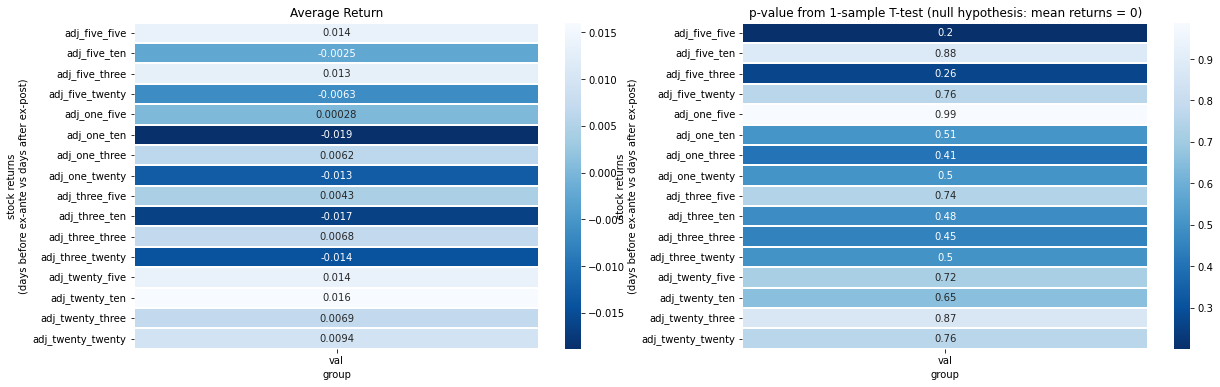

In [92]:
# mean
df_mean_pivot = df_t_test_granular_overall.pivot(index='series', columns='group', values='mean') #, columns='group'
# df_mean_pivot = df_mean_pivot.loc[order]

# p-values
df_t_test_pivot = df_t_test_granular_overall.pivot(index='series', columns='group', values='p-value') #, columns='group'
# df_t_test_pivot = df_t_test_pivot.loc[order]


fig, axs = plt.subplots(1, 2, figsize = (20,6))
sns.heatmap(df_mean_pivot, cmap = 'Blues_r',  linewidths = 0.30, annot = True, ax = axs[0])
axs[0].set_title('Average Return')
# axs[0].set_xlabel('Index rebal movement\n(ex-ante_ex-post)')
axs[0].set_ylabel('stock returns\n(days before ex-ante vs days after ex-post)')

sns.heatmap(df_t_test_pivot, cmap = 'Blues_r',  linewidths = 0.30, annot = True, ax = axs[1])
axs[1].set_title('p-value from 1-sample T-test (null hypothesis: mean returns = 0)')
# axs[1].set_xlabel('Index rebal movement\n(ex-ante_ex-post)')
axs[1].set_ylabel('stock returns\n(days before ex-ante vs days after ex-post)')

plt.show()

## Get returns of Index at the same time period

In [ ]:
# set up required lists for iteration
days_bef_ex_ante = ['twenty', 'five', 'three', 'one'] # before event
days_aft_ex_post = ['three', 'five', 'ten', 'twenty'] # after event
lst_ret_days = []

for pre_day in days_bef_ex_ante:
    for post_day in days_aft_ex_post:
        # Calculate ex-ante-ex-post return
        target_data[f'ret_{pre_day}_{post_day}'] =\
        (
            (target_data[f'post_{post_day}_pd']
             /target_data[f'pre_{pre_day}_pd']) - 1
        )
        
        lst_ret_days.append(f'ret_{pre_day}_{post_day}')

In [ ]:
target_data.head()

- Group to Year and Quarter
- get sub_buy_data, sub_sell_data for each unique Year+Quarter
    - Get multiplier for each 